In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
enss=['b','c','d']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

ens2Z_1d_V={'b':1.1262,'c':1.1573,'d':1.1930,'e':1.2175}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2amus={'b':0.0186}
ens2amuc={'b':0.249}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens2tfs={'b':range(2,22+1),'c':range(2,26+1),'d':range(2,30+1),'e':range(2,32+1)}

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN

# ens='b'
# ens2a[ens]*hbarc*1000

def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

figFolder='earlyTest5_allfits_mu=nu'

In [2]:
data={}

# stouts=range(3,13+1)
stouts=range(0,40+1)
# stouts=range(3,23+1,5)
# stouts=[4,7,10,13]
# stouts=[4,7,10,13,16,19,22,25,28,32,35,38]
flas=[f'jg;stout{stout}' for stout in stouts] + ['j+','j-','js','jc']
for ens in enss:
    data[ens]={}
    tfs=ens2tfs[ens]

    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/{ens2full[ens]}/data_earlytest/test2.h5'
    with h5py.File(path) as f:
        data[ens]['N0']=yu.jackknife(f['N_mom0'])
        data[ens]['N1']=yu.jackknife(f['N_mom1'])
        
        data[ens]['P44']={}
        data[ens]['P4i']={}
        data[ens]['P44_vev']={}
        for fla in flas:
            print(ens,fla,end='           \r')
            if ens=='e' and fla!='s':
                continue
                
            data[ens]['P44'][fla]={}
            data[ens]['P4i'][fla]={}
            for tf in tfs:
                data[ens]['P44'][fla][tf]=yu.jackknife(f[f'{fla}/P44(G0,0,0)/{tf}'][:])
                data[ens]['P4i'][fla][tf]=yu.jackknife(f[f'{fla}/P4i(G0,pi,pi)/{tf}'][:])
                
            data[ens]['P44_vev'][fla]=yu.jackknife(f[f'{fla}/P44(G0,0,0)_vev'])
            
path='data_aux/RCs.pkl'
with open(path,'rb') as f:
    ens2RCs=pickle.load(f)

In [3]:
propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(ens,figname=None):
    corrQ=True; meffQ=True
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    # if meffQ:
    #     fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    # else:
    #     fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=np.real(data[ens]['N0'])
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        # print(2,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')

    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        # print(3,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    color='orange'
    pars_jk,props_jk=yu.jackMA(fits_all)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    ax2.legend(loc=(0.6,0.5),fontsize=12)
    ax3.legend(fontsize=12)
    
    plt.tight_layout()
    # plt.savefig(figname)
    plt.close()
    return res

res_c2ptN0={}
for ens in enss[:]:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,24+1),
            'fitmins_2st':range(1,10+1),
            'fitmins_3st':range(1,4+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,17+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,20+1),
            'fitmins_3st':range(1,6+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    res_c2ptN0[ens]=run(ens,figname=f'fig/{figFolder}/fig_ignore/c2ptN0_{ens}.pdf')

In [7]:
np.mean(res_c2ptN0['b'][:,0])

0.3797464445154863

In [4]:
propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(ens,figname=None):
    corrQ=True; meffQ=True
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    # if meffQ:
    #     fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    # else:
    #     fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=np.real(data[ens]['N1'])
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        # print(2,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')

    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        # print(3,fitmin)
        tList=np.arange(fitmin,fitmax,2)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    color='orange'
    pars_jk,props_jk=yu.jackMA(fits_all)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    ax2.legend(loc=(0.6,0.5),fontsize=12)
    ax3.legend(fontsize=12)
    
    plt.tight_layout()
    # plt.savefig(figname)
    plt.close()
    return res

res_c2ptN1={}
for ens in enss[:]:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,24+1),
            'fitmins_2st':range(1,10+1),
            'fitmins_3st':range(1,4+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,17+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,20+1),
            'fitmins_3st':range(1,6+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    res_c2ptN1[ens]=run(ens,figname=f'fig/{figFolder}/fig_ignore/c2ptN1_{ens}.pdf')

In [5]:
for ens in enss:
    print(find_t_cloest(ens,0.15),find_t_cloest(ens,0.4))

2 5
2 6
3 7


(725,)        
[6.39574382e-10-7.99807118e-12j 6.79526984e-10+1.10149282e-11j
 6.66191066e-10+7.87139132e-12j 6.66518280e-10-3.28529247e-12j]
(6.419779741091782e-10+2.2610635814236117e-12j)
(400,)
[2.19005686e-11+1.34199746e-11j 6.39040834e-12+1.45474533e-11j
 2.68597542e-11+1.26617890e-11j 2.59017127e-11+1.70922543e-11j]
(1.2752418204980083e-11+1.438380378919022e-11j)
(493,)
[-1.01543073e-10-9.20071200e-12j -1.01478972e-10-8.94380712e-12j
 -1.02117065e-10-9.08866208e-12j -9.93625137e-11-9.54880253e-12j]
(-1.0313526384371867e-10-9.123504674217453e-12j)


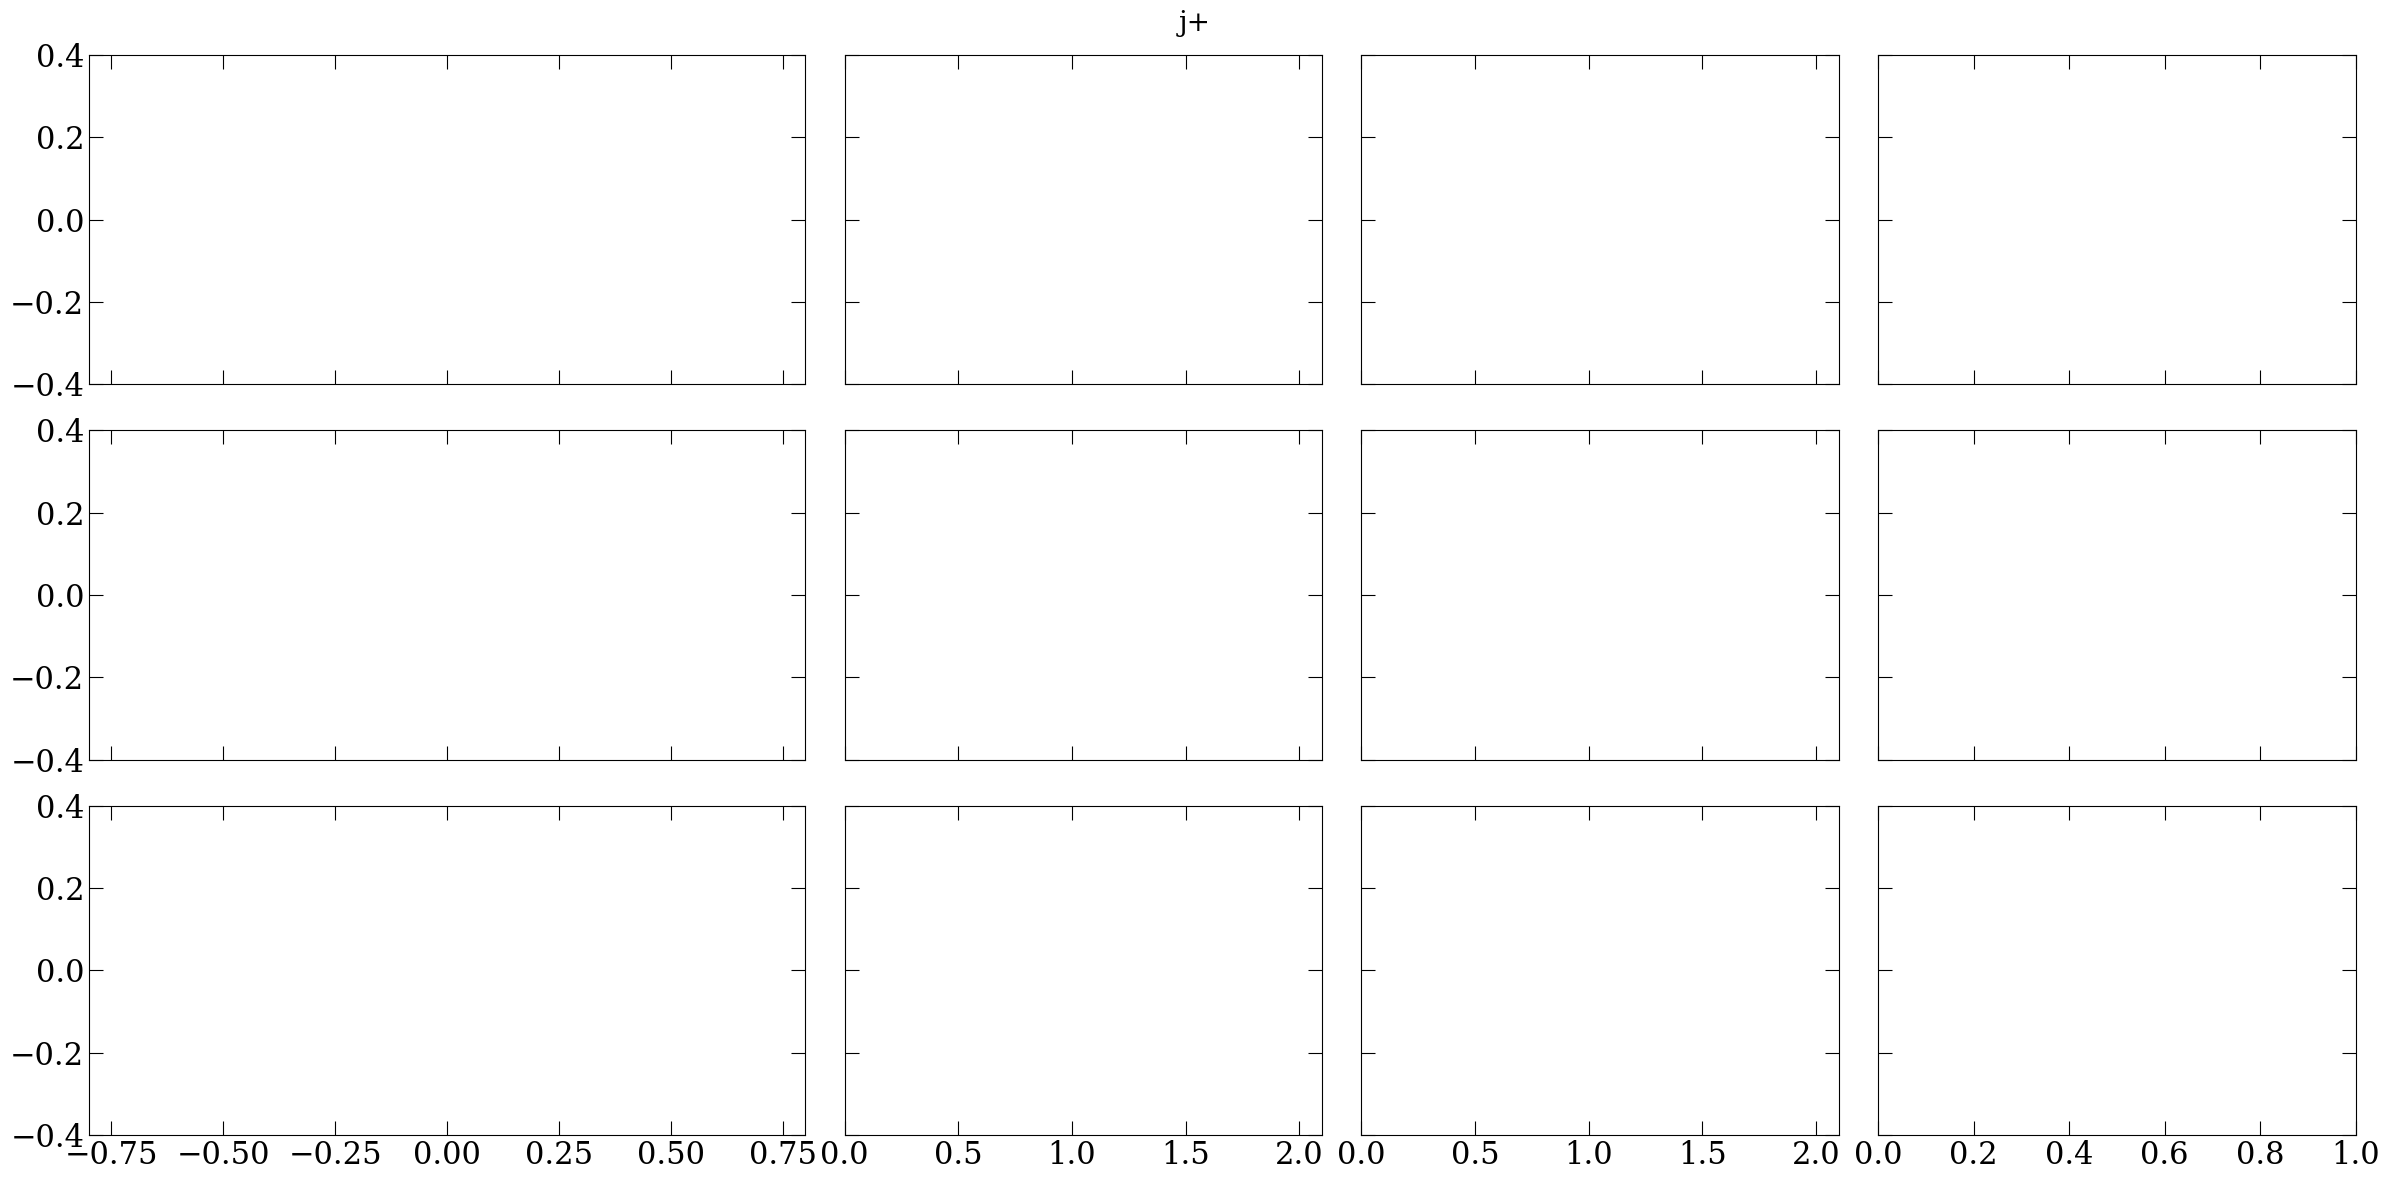

In [17]:
results_bare={ens:{} for ens in enss}

js=['j+','j-','js','jc']+[f'jg;stout{stout}' for stout in stouts]

j2ylim={
    'j+':[-0.4,0.4],'j-':[-0.01,0.01],'js':[-0.3,0.3],'jc':[-0.3,0.3],'jg':[-0.4,1.2]
}

# js=['jg;stout4','jg;stout7','jg;stout10','jg;stout13']

js=['j+']

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

func_C3pt_2st=lambda tf,tc,E0a,E0b,a00,dE1a,dE1b,ra01,ra10,ra11: a00*np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(1 + ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc)) \
    if a00!=0 else np.exp(-E0a*(tf-tc))*np.exp(-E0b*tc)*(ra01*np.exp(-dE1b*tc) + ra10*np.exp(-dE1a*(tf-tc)) + ra11*np.exp(-dE1a*(tf-tc))*np.exp(-dE1b*tc))
func_ratio_2st=lambda tf,tc,g,dE1,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1,dE1,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)
func_ratio_2st_noshare=lambda tf,tc,g,dE1,dE1t,rc1,ra01,ra11:func_C3pt_2st(tf,tc,1,1,g,dE1t,dE1t,ra01,ra01,ra11)/func_C2pt_2st(tf,1,1,dE1,rc1)

for j in js:
    print(j,end='            \r')
    enss_plt=['b','c','d']

    xlim0=[-0.8,0.8]
    xlim1=[0,2.1]
    xlim2=[0,2.1]
    xlim3=[0,2.1]

    ylim=j2ylim[j[:2]]

    fig, axs = yu.getFigAxs(len(enss_plt),4,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [3, 2, 2, 2]})
    fig.suptitle(j)
    axs[0,0].set_xlim(xlim0)
    axs[0,1].set_xlim(xlim1)
    axs[0,2].set_xlim(xlim2)
    axs[0,0].set_ylim(ylim)

    symmetrizeQ=True

    res={}; res2={}
    for i_ens,ens in enumerate(enss_plt):
        xunit=ens2a[ens]; yunit=1
        tfs=ens2tfs[ens]
        
        cN0=np.real(data[ens]['N0'])
        cN1=np.real(data[ens]['N1'])
        
        # amN=938/ens2aInv[ens]
        amN=res_c2ptN0[ens][:,0][:,None]
        
        t=data[ens]['P44'][j][3][:,0]
        print(t.shape)
        print(t[:4])
        print(np.mean(t,axis=0))
        continue
        
        c3ptDic={tf:np.real(data[ens]['P44'][j][tf]) for tf in tfs}
        vev=np.real(data[ens]['P44_vev'][j])
        ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None])/(-3*amN/4) for tf in tfs}
        
        print(vev[0])
        
        # c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
        # ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}
        
        if symmetrizeQ:
            for tf in tfs:
                ratioDic1[tf]=(ratioDic1[tf]+ratioDic1[tf][:,::-1])/2
                # ratioDic2[tf]=(ratioDic2[tf]+ratioDic2[tf][:,::-1])/2

        for iratio,ratioDic in enumerate([ratioDic1]):
            # cut_err=0.3
            # tfmax_cut=find_t_cloest(ens,2)
            # for tf in tfs:
            #     ratio=ratioDic[tf]
            #     mean,err=yu.jackme(ratio)
            #     t=err[tf//2]*yunit
            #     if t>cut_err:
            #         tfmax_cut=tf-1
            #         break
            tfmax_cut=find_t_cloest(ens,1.5)

            ax=axs[i_ens,0]
            colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
            colors_tcmin=['r','g','b','orange','purple','brown','magenta','gold','cyan']
            t_cut=1
            for i_tf,tf in enumerate(tfs):
                if tf>8:
                    continue
                if tf%2!=0 or tf>tfmax_cut:
                    continue
                ratio=ratioDic[tf]
                mean,err=yu.jackme(ratio)
                tcs=np.arange(t_cut,tf-t_cut+1)
                plt_x=(tcs-tf/2+0.02*(tf-6))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf] if i_tf<len(colors) else None)
                
            # print(ens,tfmax_cut)
            
            tcmins=list(np.arange(find_t_cloest(ens,0.2),find_t_cloest(ens,0.4)+1))
            # tcmins=[3,4,5]
            ax=axs[i_ens,1]
            for i_tcmin, tcmin in enumerate(tcmins):
                for i_tf,tf in enumerate(tfs):
                    # if tf<tcmin*2:
                    #     continue
                    ratio=ratioDic[tf]
                    if tf>2*tcmin:
                        y_jk=ratio[:,tcmin:tf-tcmin+1]
                        if symmetrizeQ:
                            y_jk=ratio[:,tcmin:tf//2+1]
                        Ndata=y_jk.shape[1]
                        def fitfunc(pars):
                            return list(pars)*Ndata
                        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    else:
                        continue
                        # pars_jk=ratio[:,tf//2] if tf%2==0 else (ratio[:,tf//2]+ratio[:,tf//2+1])/2
                        # print(tf,pars_jk.shape)
                    
                    mean,err=yu.jackme(pars_jk)
                    plt_x=(tf+i_tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                    ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin])  
            
            ax=axs[i_ens,2]
            fits=[]
            for i_tcmin, tcmin in enumerate(tcmins):
                tfmins=[tf for tf in tfs[:-3] if tf>=2*tcmin and tf<=tfmax_cut]
                for tfmin in tfmins:
                    if tfmin<tcmin*2:
                        continue
                    try:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)
                    except:
                        continue
                    if symmetrizeQ:
                        y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs if tf>=tfmin and tf<=tfmax_cut and tf%2==tfmin%2],axis=1)

                    Ndata=y_jk.shape[1]
                    def fitfunc(pars):
                        return list(pars)*Ndata
                    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
                    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
                    fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
            
            tfmins=list(set([fit[0][1] for fit in fits])); tfmins.sort()
            for tfmin in tfmins:
                t=[fit for fit in fits if fit[0][1]==tfmin]
                pars_jk,props_jk=yu.jackMA(t)
                ind_mpf=np.argmax(np.mean(props_jk,axis=0))
                fitlabel,pars_jk,chi2_jk,Ndof=t[ind_mpf]
                i_tcmin=tcmins.index(fitlabel[0])
                
                mean,err=yu.jackme(pars_jk[:,0])
                plt_x=(tfmin)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
                i_tf=tfs.index(tfmin)
                ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                
                chi2R=np.mean(chi2_jk)/Ndof
                ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/24
                ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=colors_tcmin[i_tcmin],size=8,ha='center')       
                
            pars_jk,props_jk=yu.jackMA(fits)
            results_bare[ens][j]=pars_jk[:,0]
            # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
            pars_mean,pars_err=yu.jackme(pars_jk)
            res2[ens]=[pars_mean[0],pars_err[0]]
            for icol in [0,1,2]:
                ax.set_xlim(ax.get_xlim())
                ax=axs[i_ens,icol]
                
                plt_x=ax.get_xlim(); plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
                ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='pink',alpha=0.2, label=yu.un2str(plt_y,plt_err))    
                
                if icol==2:
                    # print(ens,yu.un2str(plt_y,plt_err))
                    ax.legend()
                    
            # # 2 state fits
            # tcmins=list(np.arange(find_t_cloest(ens,0.1),find_t_cloest(ens,0.2)+1))
            # print(tcmins)
            # ax=axs[i_ens,3]
            # fits=[]
            # pars0=[pars_mean[0],1,1]
            # for i_tcmin, tcmin in enumerate(tcmins):
            #     tfmins=[tf for tf in tfs[:-(2+2*tcmin)] if tf>=2*tcmin and tf<=tfmax_cut]
            #     for tfmin in tfmins:
            #         # print(tfmin,tcmin)
            #         tfs_fit=np.arange(tfmin,tfmax_cut+1)
            #         tcs_fit={tf:np.arange(tcmin,tf//2+1,2) for tf in tfs}
            #         Ndata=np.sum([len(tcs_fit[tf]) for tf in tfs_fit])
            #         if tfmin<tcmin*2 or Ndata==0:
            #             continue
                    
            #         if symmetrizeQ:
            #             y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf//2+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)
            #         else:
            #             y_jk=np.concatenate([ratioDic[tf][:,tcmin:tf-tcmin+1:2] for tf in tfs_fit if tf>=tfmin and tf<=tfmax_cut],axis=1)

            #         Ndata=y_jk.shape[1]
            #         def fitfunc(pars):
            #             g,ra01,ra11, E0,dE1,rc1=pars
            #             t=np.concatenate([func_ratio_2st(tf,tcs_fit[tf],g,dE1,rc1,ra01,ra11) for tf in tfs_fit])
            #             return t
            #         # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04],mask='uncorrelated')
            #         pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=res_c2ptN1[ens])
            #         pars0=np.mean(pars_jk,axis=0)
            #         fits.append([(tcmin,tfmin),pars_jk,chi2_jk,Ndof])
                    
            # for fit in fits:
            #     fitlabel,pars_jk,chi2_jk,Ndof=fit
            #     tcmin,tfmin=fitlabel
            #     i_tcmin=tcmins.index(tcmin)
                
            #     mean,err=yu.jackme(pars_jk[:,0])
            #     plt_x=(tfmin+tcmin*0.1)*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            #     i_tf=tfs.index(tfmin)
            #     ax.errorbar(plt_x,plt_y,plt_yerr,color=colors_tcmin[i_tcmin]) 
                   
                
            
    plt.tight_layout()
    # plt.savefig(f'fig/{figFolder}/fig_ignore/{j}.pdf')
    # plt.close()

In [6]:
tconn_isos={}
tconn_isov={}

# divides={'b':1.151,'c':1.137,'d':1.173}
divides={'b':1.1167,'c':1.1460,'d':1.1807}
for ens in enss:
    print(ens.upper())

    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_fromCK/{ens.upper()}_isos_A20_msq00_wa3_WLS_newRenorm.npy'
    t=np.load(path)
    mean,err=yu.jackme(t)
    print(yu.un2str(mean,err),mean,err)
    tconn_isos[ens]=[mean,err]
    
    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/data_fromCK/{ens.upper()}_isov_A20_msq00_wa3_WLS_newRenorm.npy'
    t=np.load(path)
    mean,err=yu.jackme(t/divides[ens])
    print(yu.un2str(mean,err),mean,err)
    tconn_isov[ens]=[mean,err]

B
0.367(23) 0.3667208148713367 0.022835641718876788
0.150(12) 0.1503314586650251 0.011996812443649295
C
0.344(14) 0.34439247540716045 0.01400843867752095
0.1369(72) 0.1368736086667962 0.007219977588091443
D
0.326(16) 0.3257547228611291 0.015781254664977314
0.1338(72) 0.133788869764531 0.007194935556011403


In [7]:
for ens in enss:
    Ncfg=len(data[ens]['N0'])
    mean,err=tconn_isos[ens]
    t=yu.jackknife_pseudo([mean],np.array([[err**2]]),Ncfg)
    results_bare[ens]['j+_conn']=t[:,0]
    
    mean,err=tconn_isov[ens]
    t=yu.jackknife_pseudo([mean],np.array([[err**2]]),Ncfg)
    results_bare[ens]['j-_conn']=t[:,0]

In [16]:
print(0.373,ens2RCs['b']['Zqq^s(mu=nu)'],0.0695,ens2RCs['b']['Zqq^s(mu!=nu)'])
print(0.350,1.15, 0.109, 1.16)
print()
print(0.373*ens2RCs['b']['Zqq^s(mu=nu)'],0.0695*ens2RCs['b']['Zqq^s(mu!=nu)'],0.373*ens2RCs['b']['Zqq^s(mu=nu)']+0.0695*ens2RCs['b']['Zqq^s(mu!=nu)'])
print(0.350*1.15, 0.109*1.16, 0.350*1.15+0.109*1.16, 0.36+0.19)

0.373 1.075 0.0695 1.134
0.35 1.15 0.109 1.16

0.40097499999999997 0.078813 0.479788
0.40249999999999997 0.12644 0.52894 0.55


In [8]:
results={ens:{} for ens in enss}

factor_RCerr=1
for ens in enss:
    # non-singlets
    Ncfg=len(data[ens]['N0'])
    Zconn=yu.jackknife_pseudo([ens2RCs[ens]['Zqq(mu=nu)']],np.array([[ens2RCs[ens]['Zqq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zdisc=yu.jackknife_pseudo([ens2RCs[ens]['Zqq(mu=nu)']],np.array([[ens2RCs[ens]['Zqq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    tconn_upd=results_bare[ens]['j+_conn']
    tconn_umd=results_bare[ens]['j-_conn']
    tconn_u=(tconn_upd+tconn_umd)/2
    tconn_d=(tconn_upd-tconn_umd)/2
    tupd=results_bare[ens]['j+']
    tumd=0
    # tumd=results_bare[ens]['j-']
    tu=(tupd+tumd)/2
    td=(tupd-tumd)/2
    ts=results_bare[ens]['js']
    tc=results_bare[ens]['jc']
    
    # results[ens]['u+d-s-c'] = Zconn*tconn_upd + Zdisc*(tupd-ts-tc)
    results[ens]['3u-d-s-c'] = Zconn*(tconn_upd+2*tconn_umd) + Zdisc*(tupd-ts-tc)
    results[ens]['3d-u-s-c'] = Zconn*(tconn_upd-2*tconn_umd) + Zdisc*(tupd-ts-tc)
    results[ens]['3s-u-d-c'] = -Zconn*tconn_upd + Zdisc*(3*ts-tupd-tc)
    results[ens]['3c-u-d-s'] = -Zconn*tconn_upd + Zdisc*(3*tc-tupd-ts)
    
    # singlet & gluon
    for stout in stouts: 
    # for stout in [10]: 
        Zqq_conn=yu.jackknife_pseudo([ens2RCs[ens]['Zqq^s(mu=nu)']],np.array([[ens2RCs[ens]['Zqq^s(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
        Zqq_disc=yu.jackknife_pseudo([ens2RCs[ens]['Zqq^s(mu=nu)']],np.array([[ens2RCs[ens]['Zqq^s(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
        Zqg=yu.jackknife_pseudo([ens2RCs[ens]['Zqg(mu!=nu)']],np.array([[ens2RCs[ens]['Zqg(mu!=nu)_err']**2]])+0.0001,Ncfg)[:,0]
        tg=results_bare[ens][f'jg;stout{stout}']
        results[ens][f'u+d+s+c;{stout}'] = Zqq_conn*tconn_upd + Zqq_disc*(tupd+ts+tc) + Zqg*tg
        
        results[ens][f'u;{stout}']= Zconn*tconn_u+Zdisc*tu + (Zqq_conn-Zconn)*(tconn_upd+tupd+ts+tc)/4 + Zqg*tg/4
        results[ens][f'd;{stout}']= Zconn*tconn_d+Zdisc*td + (Zqq_conn-Zconn)*(tconn_upd+tupd+ts+tc)/4 + Zqg*tg/4
        results[ens][f's;{stout}']= Zconn*0+Zdisc*ts + (Zqq_conn-Zconn)*(tconn_upd+tupd+ts+tc)/4 + Zqg*tg/4
        results[ens][f'c;{stout}']= Zconn*0+Zdisc*tc + (Zqq_conn-Zconn)*(tconn_upd+tupd+ts+tc)/4 + Zqg*tg/4
        
        Zgg=yu.jackknife_pseudo([ens2RCs[ens][f'Zgg^{stout}(mu!=nu)']],np.array([[ens2RCs[ens][f'Zgg^{stout}(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
        Zgq_conn=yu.jackknife_pseudo([ens2RCs[ens][f'Zgq(mu=nu)']],np.array([[ens2RCs[ens][f'Zgq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
        Zgq_disc=yu.jackknife_pseudo([ens2RCs[ens][f'Zgq(mu!=nu)']],np.array([[ens2RCs[ens][f'Zgq(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
        results[ens][f'g;{stout}'] = Zgg*tg + Zgq_conn*tconn_upd + Zgq_disc*(tupd+ts+tc)
        results[ens][f'g_noMixing;{stout}'] = Zgg*tg

In [11]:
# results={ens:{} for ens in enss}

# factor_RCerr=1
# for ens in enss:
#     # non-singlets
#     Ncfg=len(data[ens]['N0'])
#     Zconn=yu.jackknife_pseudo([ens2RCs[ens]['Zqq(mu=nu)']],np.array([[ens2RCs[ens]['Zqq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
#     Zdisc=yu.jackknife_pseudo([ens2RCs[ens]['Zqq(mu!=nu)']],np.array([[ens2RCs[ens]['Zqq(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
#     tdat={}
    
#     tdat['upd_conn']=results_bare[ens]['j+_conn']
#     tdat['umd_conn']=results_bare[ens]['j+_conn']
#     tdat['u_conn']=(tdat['upd_conn']+tdat['umd_conn'])/2
#     tdat['d_conn']=(tdat['upd_conn']-tdat['umd_conn'])/2
    
#     tdat['upd']=results_bare[ens]['j+']
#     tdat['umd']=0  #results_bare[ens]['j-']
#     tdat['u']=(tdat['upd']+tdat['umd'])/2
#     tdat['d']=(tdat['upd']-tdat['umd'])/2
    
#     tdat['s']=results_bare[ens]['js']
#     tdat['c']=results_bare[ens]['jc']
    
    
#     results[ens]['u+d-s-c'] = Zconn*tconn + Zdisc*(tud-ts-tc)
#     results[ens]['3s-u-d-c'] = -Zconn*tconn + Zdisc*(3*ts-tud-tc)
#     results[ens]['3c-u-d-s'] = -Zconn*tconn + Zdisc*(3*tc-tud-ts)
    
#     # singlet & gluon
#     for stout in stouts:
#         Zqq_conn=yu.jackknife_pseudo([ens2RCs[ens]['Zqq^s(mu=nu)']],np.array([[ens2RCs[ens]['Zqq^s(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
#         Zqq_disc=yu.jackknife_pseudo([ens2RCs[ens]['Zqq^s(mu!=nu)']],np.array([[ens2RCs[ens]['Zqq^s(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
#         Zqg=yu.jackknife_pseudo([ens2RCs[ens]['Zqg(mu!=nu)']],np.array([[ens2RCs[ens]['Zqg(mu!=nu)_err']**2]])+0.0001,Ncfg)[:,0]
#         tg=results_bare[ens][f'jg;stout{stout}']
#         results[ens][f'u+d+s+c;{stout}'] = Zqq_conn*tconn + Zqq_disc*(tud+ts+tc) + Zqg*tg
        
#         Zgg=yu.jackknife_pseudo([ens2RCs[ens][f'Zgg^{stout}(mu!=nu)']],np.array([[ens2RCs[ens][f'Zgg^{stout}(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
#         Zgq_conn=yu.jackknife_pseudo([ens2RCs[ens][f'Zgq(mu=nu)']],np.array([[ens2RCs[ens][f'Zgq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
#         Zgq_disc=yu.jackknife_pseudo([ens2RCs[ens][f'Zgq(mu!=nu)']],np.array([[ens2RCs[ens][f'Zgq(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
#         results[ens][f'g;{stout}'] = Zgg*tg + Zgq_conn*tconn + Zgq_disc*(tud+ts+tc)

In [9]:
ens='b'
Ncfg=len(data[ens]['N0'])
factor_RCerr=1

# old results for B
bare_old={
    'j+_conn':[0.350,0.035],
    'j-_conn':[0.149,0.016],
    'j+':[0.109,0.020],
    'j-':[0,1e-7],
    'js':[0.038,0.010],
    'jc':[0.008,0.008],
    'jg;stout10':[0.407,0.054]
}

for key,val in bare_old.items():
    mean,err=val
    bare_old[key]=yu.jackknife_pseudo([mean],np.array([[err**2]]),Ncfg)[:,0]

RCs_old={
    'Zqq(mu=nu)':1.151, 'Zqq(mu=nu)_err':0.004,
    'Zqq(mu!=nu)':1.160, 'Zqq(mu!=nu)_err':0.003,
    'Zqq^s(mu=nu)':1.151, 'Zqq^s(mu=nu)_err':0.004,
    'Zqq^s(mu!=nu)':1.160, 'Zqq^s(mu!=nu)_err':0.003,
    
    # 'Zqg(mu!=nu)':0, 'Zqg(mu!=nu)_err':1e-7,
    # 'Zgq(mu=nu)':0, 'Zgq(mu=nu)_err':1e-7,
    # 'Zgq(mu!=nu)':0, 'Zgq(mu!=nu)_err':1e-7,
    
    # 'Zqg(mu!=nu)':-0.027, 'Zqg(mu!=nu)_err':1e-7,
    # 'Zgq(mu=nu)':0.232, 'Zgq(mu=nu)_err':1e-7,
    # 'Zgq(mu!=nu)':0.083, 'Zgq(mu!=nu)_err':1e-7,
    
    # 'Zqg(mu!=nu)':0.083, 'Zqg(mu!=nu)_err':1e-7,
    # 'Zgq(mu=nu)':-0.027, 'Zgq(mu=nu)_err':1e-7,
    # 'Zgq(mu!=nu)':0, 'Zgq(mu!=nu)_err':1e-7,
    
    'Zqg(mu!=nu)':0.083, 'Zqg(mu!=nu)_err':1e-7,
    'Zgq(mu=nu)':-0.027, 'Zgq(mu=nu)_err':1e-7,
    'Zgq(mu!=nu)':-0.027, 'Zgq(mu!=nu)_err':1e-7,
    
    'Zgg^10(mu!=nu)':1.08, 'Zgg^10(mu!=nu)_err':0.17, 
}

results_Zold_Bold={}
results_Zold_Bnew={}
results_Znew_Bold={}

# non-singlets
Zconn=yu.jackknife_pseudo([ens2RCs[ens]['Zqq(mu=nu)']],np.array([[ens2RCs[ens]['Zqq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
Zdisc=yu.jackknife_pseudo([ens2RCs[ens]['Zqq(mu!=nu)']],np.array([[ens2RCs[ens]['Zqq(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
tconn_upd=results_bare[ens]['j+_conn']
tconn_umd=results_bare[ens]['j-_conn']
tconn_u=(tconn_upd+tconn_umd)/2
tconn_d=(tconn_upd-tconn_umd)/2
tupd=results_bare[ens]['j+']
tumd=0
# tumd=results_bare[ens]['j-']
tu=(tupd+tumd)/2
td=(tupd-tumd)/2
ts=results_bare[ens]['js']
tc=results_bare[ens]['jc']

Zconn_old=yu.jackknife_pseudo([RCs_old['Zqq(mu=nu)']],np.array([[RCs_old['Zqq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
Zdisc_old=yu.jackknife_pseudo([RCs_old['Zqq(mu!=nu)']],np.array([[RCs_old['Zqq(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
tconn_upd_old=bare_old['j+_conn']
tconn_umd_old=bare_old['j-_conn']
tconn_u_old=(tconn_upd_old+tconn_umd_old)/2
tconn_d_old=(tconn_upd_old-tconn_umd_old)/2
tupd_old=bare_old['j+']
tumd_old=0
# tumd=results_bare[ens]['j-']
tu_old=(tupd_old+tumd_old)/2
td_old=(tupd_old-tumd_old)/2
ts_old=bare_old['js']
tc_old=bare_old['jc']

# singlet & gluon
for stout in [10]: 
# for stout in [10]: 
    Zqq_conn=yu.jackknife_pseudo([ens2RCs[ens]['Zqq^s(mu=nu)']],np.array([[ens2RCs[ens]['Zqq^s(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zqq_disc=yu.jackknife_pseudo([ens2RCs[ens]['Zqq^s(mu!=nu)']],np.array([[ens2RCs[ens]['Zqq^s(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zqg=yu.jackknife_pseudo([ens2RCs[ens]['Zqg(mu!=nu)']],np.array([[ens2RCs[ens]['Zqg(mu!=nu)_err']**2]])+0.0001,Ncfg)[:,0]
    tg=results_bare[ens][f'jg;stout{stout}']
    results[ens][f'u+d+s+c;{stout}'] = Zqq_conn*tconn_upd + Zqq_disc*(tupd+ts+tc) + Zqg*tg
    
    Zqq_conn_old=yu.jackknife_pseudo([RCs_old['Zqq^s(mu=nu)']],np.array([[RCs_old['Zqq^s(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zqq_disc_old=yu.jackknife_pseudo([RCs_old['Zqq^s(mu!=nu)']],np.array([[RCs_old['Zqq^s(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zqg_old=yu.jackknife_pseudo([RCs_old['Zqg(mu!=nu)']],np.array([[RCs_old['Zqg(mu!=nu)_err']**2]])+0.0001,Ncfg)[:,0]
    tg_old=bare_old[f'jg;stout{stout}']
    results_Zold_Bold[f'u+d+s+c;{stout}'] = Zqq_conn_old*tconn_upd_old + Zqq_disc_old*(tupd_old+ts_old+tc_old) + Zqg_old*tg_old
    results_Zold_Bnew[f'u+d+s+c;{stout}'] = Zqq_conn_old*tconn_upd + Zqq_disc_old*(tupd+ts+tc) + Zqg_old*tg
    results_Znew_Bold[f'u+d+s+c;{stout}'] = Zqq_conn*tconn_upd_old + Zqq_disc*(tupd_old+ts_old+tc_old) + Zqg*tg_old
    
    results[ens][f'u;{stout}']= Zconn*tconn_u+Zdisc*tu + (Zqq_conn-Zconn)*(tconn_upd+tupd+ts+tc)/4 + Zqg*tg/4
    results[ens][f'd;{stout}']= Zconn*tconn_d+Zdisc*td + (Zqq_conn-Zconn)*(tconn_upd+tupd+ts+tc)/4 + Zqg*tg/4
    results[ens][f's;{stout}']= Zconn*0+Zdisc*ts + (Zqq_conn-Zconn)*(tconn_upd+tupd+ts+tc)/4 + Zqg*tg/4
    results[ens][f'c;{stout}']= Zconn*0+Zdisc*tc + (Zqq_conn-Zconn)*(tconn_upd+tupd+ts+tc)/4 + Zqg*tg/4
    
    results_Zold_Bold[f'u;{stout}']= Zconn_old*tconn_u_old+Zdisc_old*tu_old + (Zqq_conn_old-Zconn_old)*(tconn_upd_old+tupd_old+ts_old+tc_old)/4 + Zqg_old*tg_old/4
    results_Zold_Bold[f'd;{stout}']= Zconn_old*tconn_d_old+Zdisc_old*td_old + (Zqq_conn_old-Zconn_old)*(tconn_upd_old+tupd_old+ts_old+tc_old)/4 + Zqg_old*tg_old/4
    results_Zold_Bold[f's;{stout}']= Zconn_old*0+Zdisc_old*ts_old + (Zqq_conn_old-Zconn_old)*(tconn_upd_old+tupd_old+ts_old+tc_old)/4 + Zqg_old*tg_old/4
    results_Zold_Bold[f'c;{stout}']= Zconn_old*0+Zdisc_old*tc_old + (Zqq_conn_old-Zconn_old)*(tconn_upd_old+tupd_old+ts_old+tc_old)/4 + Zqg_old*tg_old/4
    
    results_Zold_Bnew[f'u;{stout}']= Zconn_old*tconn_u+Zdisc_old*tu + (Zqq_conn_old-Zconn_old)*(tconn_upd+tupd+ts+tc)/4 + Zqg_old*tg/4
    results_Zold_Bnew[f'd;{stout}']= Zconn_old*tconn_d+Zdisc_old*td + (Zqq_conn_old-Zconn_old)*(tconn_upd+tupd+ts+tc)/4 + Zqg_old*tg/4
    results_Zold_Bnew[f's;{stout}']= Zconn_old*0+Zdisc_old*ts + (Zqq_conn_old-Zconn_old)*(tconn_upd+tupd+ts+tc)/4 + Zqg_old*tg/4
    results_Zold_Bnew[f'c;{stout}']= Zconn_old*0+Zdisc_old*tc + (Zqq_conn_old-Zconn_old)*(tconn_upd+tupd+ts+tc)/4 + Zqg_old*tg/4
    
    results_Znew_Bold[f'u;{stout}']= Zconn*tconn_u_old+Zdisc*tu_old + (Zqq_conn-Zconn)*(tconn_upd_old+tupd_old+ts_old+tc_old)/4 + Zqg*tg_old/4
    results_Znew_Bold[f'd;{stout}']= Zconn*tconn_d_old+Zdisc*td_old + (Zqq_conn-Zconn)*(tconn_upd_old+tupd_old+ts_old+tc_old)/4 + Zqg*tg_old/4
    results_Znew_Bold[f's;{stout}']= Zconn*0+Zdisc*ts_old + (Zqq_conn-Zconn)*(tconn_upd_old+tupd_old+ts_old+tc_old)/4 + Zqg*tg_old/4
    results_Znew_Bold[f'c;{stout}']= Zconn*0+Zdisc*tc_old + (Zqq_conn-Zconn)*(tconn_upd_old+tupd_old+ts_old+tc_old)/4 + Zqg*tg_old/4
    
    Zgg=yu.jackknife_pseudo([ens2RCs[ens][f'Zgg^{stout}(mu!=nu)']],np.array([[ens2RCs[ens][f'Zgg^{stout}(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zgq_conn=yu.jackknife_pseudo([ens2RCs[ens][f'Zgq(mu=nu)']],np.array([[ens2RCs[ens][f'Zgq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zgq_disc=yu.jackknife_pseudo([ens2RCs[ens][f'Zgq(mu!=nu)']],np.array([[ens2RCs[ens][f'Zgq(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    results[ens][f'g;{stout}'] = Zgg*tg + Zgq_conn*tconn_upd + Zgq_disc*(tupd+ts+tc)
    results[ens][f'g_noMixing;{stout}'] = Zgg*tg

    Zgg_old=yu.jackknife_pseudo([RCs_old[f'Zgg^{stout}(mu!=nu)']],np.array([[RCs_old[f'Zgg^{stout}(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zgq_conn_old=yu.jackknife_pseudo([RCs_old[f'Zgq(mu=nu)']],np.array([[RCs_old[f'Zgq(mu=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    Zgq_disc_old=yu.jackknife_pseudo([RCs_old[f'Zgq(mu!=nu)']],np.array([[RCs_old[f'Zgq(mu!=nu)_err']**2]])*factor_RCerr,Ncfg)[:,0]
    
    results_Zold_Bold[f'g;{stout}'] = Zgg_old*tg_old + Zgq_conn_old*tconn_upd_old + Zgq_disc_old*(tupd_old+ts_old+tc_old)
    results_Zold_Bnew[f'g;{stout}'] = Zgg_old*tg + Zgq_conn_old*tconn_upd + Zgq_disc_old*(tupd+ts+tc)
    results_Znew_Bold[f'g;{stout}'] = Zgg*tg_old + Zgq_conn*tconn_upd_old + Zgq_disc*(tupd_old+ts_old+tc_old)

In [13]:
1.08*0.407 + 0.232*(0.350) + 0.083*(0.109+0.038+0.008) , 1.08*0.407 - 0.027 *(0.350) - 0.027 *(0.109+0.038+0.008) 

(0.533625, 0.425925)

In [16]:
enss_plt=['b','c','d']
stouts_plt=[4,7,10,13]
stouts_plt=stouts
stouts_plt=range(5,45,5)
# stouts_plt=[10]
avgxs=['u','d','s','c','q','g','tot']
fig, axs = yu.getFigAxs(len(avgxs),len(stouts_plt),Lrow=4,Lcol=8,sharex=True,sharey='row')
yu.addRowHeader(axs,avgxs)
yu.addColHeader(axs,stouts_plt)
results['a=0']={}
for istout,stout in enumerate(stouts_plt):
    for iavgx,avgx in enumerate(avgxs):
        ax=axs[iavgx,istout]
        
        def ens2res(ens):
            if avgx=='q':
                results[ens][f'{avgx};{stout}'] = results[ens][f'u+d+s+c;{stout}']
            if avgx=='tot':
                results[ens][f'{avgx};{stout}'] = results[ens][f'u+d+s+c;{stout}'] + results[ens][f'g;{stout}']
            return results[ens][f'{avgx};{stout}']

        tdic={ens:yu.jackme(ens2res(ens)) for ens in enss_plt}

        a2s=np.array([ens2a[ens]**2 for ens in enss_plt])
        gs_m=np.array([tdic[ens][0] for ens in enss_plt])
        gs_e=np.array([tdic[ens][1] for ens in enss_plt])

        ax.errorbar(a2s,gs_m,gs_e,color='r') 
        
        if avgx in ['u','d','s','c','q','g','tot']:
            if stout==10:   
                y,yerr={'u':(0.359,0.030),'d':(0.188,0.019),'s':(0.052,0.012),'c':(0.019,0.009),'q':(0.618,0.06),'g':(0.427,0.092),'tot':(1.045,0.118)}[avgx]
                ax.errorbar(a2s[0]+0.0002,y,yerr,color='black')
            
                if avgx in ['u','d','s','c']:
                    t=results_Zold_Bold[f'{avgx};{stout}']
                if avgx=='q':
                    t=results_Zold_Bold[f'u+d+s+c;{stout}']
                if avgx=='g':
                    t=results_Zold_Bold[f'g;{stout}']
                if avgx=='tot':
                    t=results_Zold_Bold[f'u+d+s+c;{stout}'] + results_Zold_Bold[f'g;{stout}']
                y,yerr=yu.jackme(t)
                ax.errorbar(a2s[0]+0.0003,y,yerr,color='g')
                
                if avgx in ['u','d','s','c']:
                    t=results_Znew_Bold[f'{avgx};{stout}']
                if avgx=='q':
                    t=results_Znew_Bold[f'u+d+s+c;{stout}']
                if avgx=='g':
                    t=results_Znew_Bold[f'g;{stout}']
                if avgx=='tot':
                    t=results_Znew_Bold[f'u+d+s+c;{stout}'] + results_Znew_Bold[f'g;{stout}']
                y,yerr=yu.jackme(t)
                ax.errorbar(a2s[0]+0.0004,y,yerr,color='b')
                
                if avgx in ['u','d','s','c']:
                    t=results_Zold_Bnew[f'{avgx};{stout}']
                if avgx=='q':
                    t=results_Zold_Bnew[f'u+d+s+c;{stout}']
                if avgx=='g':
                    t=results_Zold_Bnew[f'g;{stout}']
                if avgx=='tot':
                    t=results_Zold_Bnew[f'u+d+s+c;{stout}'] + results_Zold_Bnew[f'g;{stout}']
                y,yerr=yu.jackme(t)
                ax.errorbar(a2s[0]+0.0005,y,yerr,color='orange')

        
        fits=[]
        
        # const
        mean=gs_m; err=gs_e
        def fitfunc(a2,g):
            return g+0*a2
        popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
        r=fitfunc(a2s,*popt)-mean
        color='g'
        chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss_plt)-1)
        a2s2=np.arange(0,0.008,0.001)

        mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
        # ax.plot(a2s2,mean,'--',color=color)
        # ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
        # ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color, label=yu.un2str(popt[0],np.sqrt(pcov[0,0])))
        # ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        # ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)
        
        pars_mean=mean; pars_err=err; Ndof=(len(enss_plt)-1); chi2=chi2R*Ndof
        fits.append([pars_mean,pars_err,chi2,Ndof])
        # print('c.l._const',yu.un2str(popt[0],np.sqrt(pcov[0,0])))
        
        # linear
        mean=gs_m; err=gs_e
        def fitfunc(a2,g,c):
            return g+c*a2
        popt,pcov=curve_fit(fitfunc,a2s,mean,sigma=err,absolute_sigma=True)
        r=fitfunc(a2s,*popt)-mean
        color='b'
        chi2R=r.T @ np.linalg.inv(np.diag(err**2)) @ r / (len(enss_plt)-2)
        a2s2=np.arange(0,0.008,0.001)

        mean,err,cov=yu.propagateError(lambda pars:fitfunc(a2s2,*pars), popt, pcov)
        # ax.plot(a2s2,mean,'--',color=color)
        # ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
        # ax.errorbar([0],[popt[0]],np.sqrt(pcov[0,0]),color=color, label=yu.un2str(popt[0],np.sqrt(pcov[0,0])))
        # ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        # ax.annotate("%0.1f" %chi2R,(0,popt[0]-np.sqrt(pcov[0,0])-chi2_shift),color=color)
        
        pars_mean=mean; pars_err=err; Ndof=(len(enss_plt)-2); chi2=chi2R*Ndof
        fits.append([pars_mean,pars_err,chi2,Ndof])
        # print('c.l._linear',yu.un2str(popt[0],np.sqrt(pcov[0,0])))
        
        (pars_mean_MA,pars_err_MA,props)=yu.modelAvg(fits)
        # print('model avg',yu.un2str(pars_mean_MA[0],pars_err_MA[0]))
        # print(props)
                            
        color='orange'
        ax.errorbar([0],pars_mean_MA[0],pars_err_MA[0],color=color, label=yu.un2str(pars_mean_MA[0],pars_err_MA[0]))
        mean=pars_mean_MA; err=pars_err_MA
        ax.plot(a2s2,mean,'--',color=color)
        ax.fill_between(a2s2,mean-err,mean+err,color=color,alpha=0.2)
        results['a=0'][f'{avgx};{stout}']=(pars_mean_MA[0],pars_err_MA[0])
        
        ax.legend(fontsize=16)

plt.tight_layout()
plt.savefig(f'fig/{figFolder}/avgxs.pdf')
plt.close()

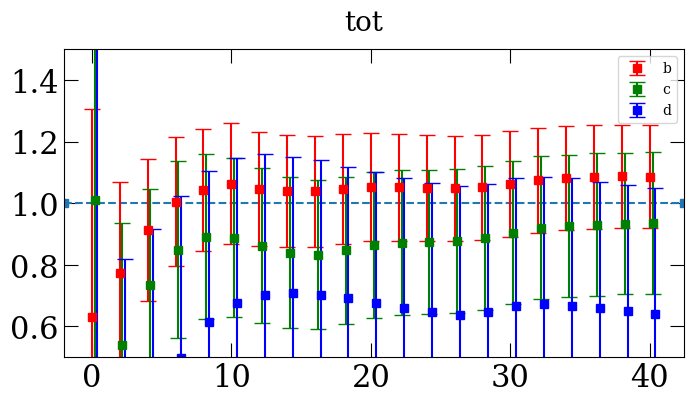

In [12]:
fig, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=8)
fig.suptitle('tot')
ax=axs[0,0]
ax.set_ylim([0.5,1.5])
ax.axhline(1,ls='--')

colors=['r','g','b']
for stout in stouts:
    if stout%2!=0:
        continue
    for iens,ens in enumerate(enss):
        plt_x=stout+0.2*iens; plt_y,plt_yerr=yu.jackme(results[ens][f'tot;{stout}'])
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens],label=ens if stout==0 else None)

ax.legend(fontsize=10)
plt.savefig(f'fig/{figFolder}/stoutDependence_tot.pdf')

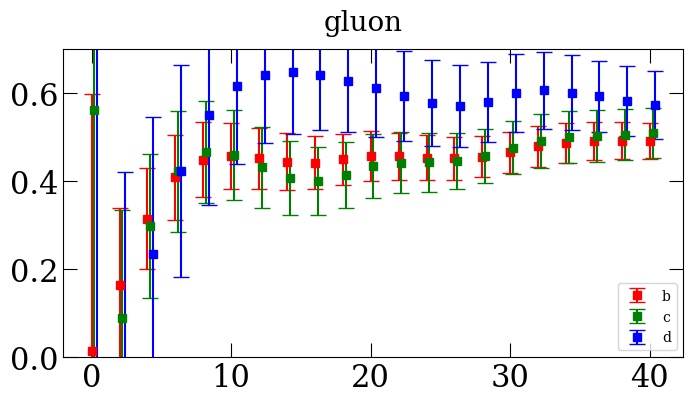

In [13]:
fig, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=8)
fig.suptitle('gluon')
ax=axs[0,0]
ax.set_ylim([0.,.7])
ax.axhline(1,ls='--')

colors=['r','g','b']
for stout in stouts:
    if stout%2!=0:
        continue
    for iens,ens in enumerate(enss):
        plt_x=stout+0.2*iens; plt_y,plt_yerr=yu.jackme(results[ens][f'g;{stout}'])
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens],label=ens if stout==0 else None)

ax.legend(fontsize=10)
plt.savefig(f'fig/{figFolder}/stoutDependence_gluon.pdf')

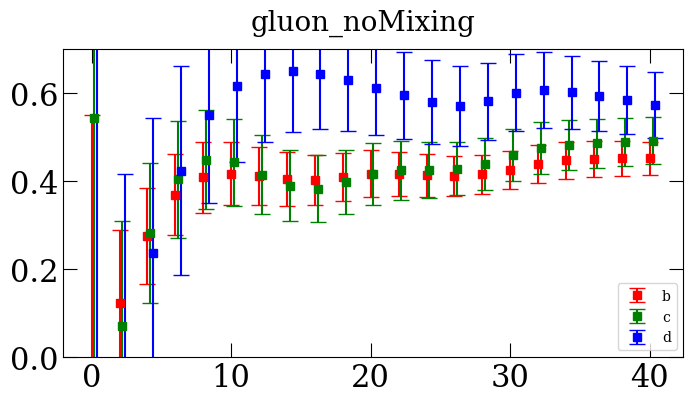

In [14]:
fig, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=8)
fig.suptitle('gluon_noMixing')
ax=axs[0,0]
ax.set_ylim([0.,.7])
ax.axhline(1,ls='--')

colors=['r','g','b']
for stout in stouts:
    if stout%2!=0:
        continue
    for iens,ens in enumerate(enss):
        plt_x=stout+0.2*iens; plt_y,plt_yerr=yu.jackme(results[ens][f'g_noMixing;{stout}'])
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens],label=ens if stout==0 else None)

ax.legend(fontsize=10)
plt.savefig(f'fig/{figFolder}/stoutDependence_gluon_noMixing.pdf')

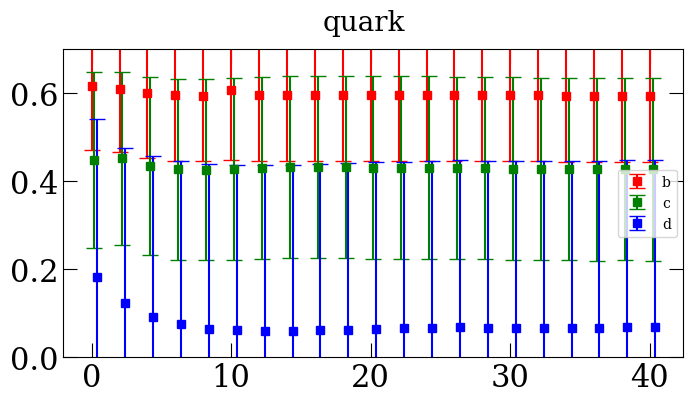

In [15]:
fig, axs = yu.getFigAxs(1,1,Lrow=4,Lcol=8)
fig.suptitle('quark')
ax=axs[0,0]
ax.set_ylim([0.,.7])
ax.axhline(1,ls='--')

colors=['r','g','b']
for stout in stouts:
    if stout%2!=0:
        continue
    for iens,ens in enumerate(enss):
        plt_x=stout+0.2*iens; plt_y,plt_yerr=yu.jackme(results[ens][f'q;{stout}'])
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[iens],label=ens if stout==0 else None)

ax.legend(fontsize=10)
plt.savefig(f'fig/{figFolder}/stoutDependence_quark.pdf')